In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

data = load_iris()
data.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])

In [2]:
#plotting everything in 2D so we only use 2 features here
X = data["data"].copy()[ :, 2:4]# 2 columns to allow straightforward decision boundary visualization
y = data["target"].copy()

stratSplit = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
for train_index, test_index in stratSplit.split(X, y):
    X_train = X[train_index]
    X_test = X[test_index]
    
    y_train = y[train_index]
    y_test = y[test_index]

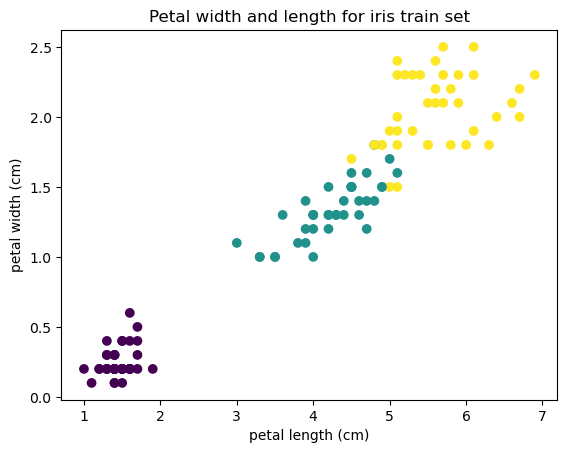

In [7]:
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train)
plt.xlabel(data["feature_names"][2]) #feature name at index 2
plt.ylabel(data["feature_names"][3]) #feature name at index 3
plt.title("Petal width and length for iris train set")
plt.savefig("irisSimpleScatter.png", bbox_inches="tight")
plt.show()

In [8]:
def plotDecisionBoundary(svc, X, y, X_train, y_train, title):
    h = .02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    xx_r = xx.ravel()
    yy_r = yy.ravel()
    Z = svc.predict(np.c_[xx_r, yy_r])

    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train)
    plt.scatter(X[:, 0],X[:, 1],c=y, cmap=plt.cm.cool)
    plt.title(title)
    plt.show()

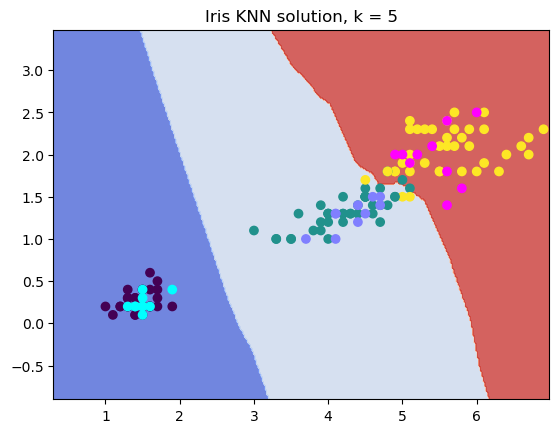

Train score: 0.95
Test score: 1.0


In [13]:
from sklearn.neighbors import KNeighborsClassifier
k = 5 #k nearest (border tuning)
p = 2 #distance (2=Euclidean) for finding the neighbors
knn_clf = KNeighborsClassifier(n_neighbors=k,
                               weights="uniform",# weights to use for votes from k neighbor, 
                                                 # can also be distance or custom
                                                 #uniform: each neighbor carries the same vote
                               n_jobs = -1,# for neighborhood search, doesn't affect fit
                               algorithm = "auto",# tree vs brute force
                               leaf_size = 30, # leave size until tree switches to brute force
                               p = p,# metric order to use for minkowski neighborhood construction
                               metric = "minkowski",# distance metric to use for neighborhood construction
                                                    # can also use other distance metrics from sklearn or custom
                               metric_params = None 
                              )

knn_clf.fit(X_train, y_train)
plotDecisionBoundary(knn_clf, X_test, y_test, X_train, 
                     y_train, title=f"Iris KNN solution, k = {k}")
print("Train score:",knn_clf.score(X_train, y_train))
print("Test score:",knn_clf.score(X_test, y_test))

#result: inconsistencies didn't effect the test set cause we got a 1.0

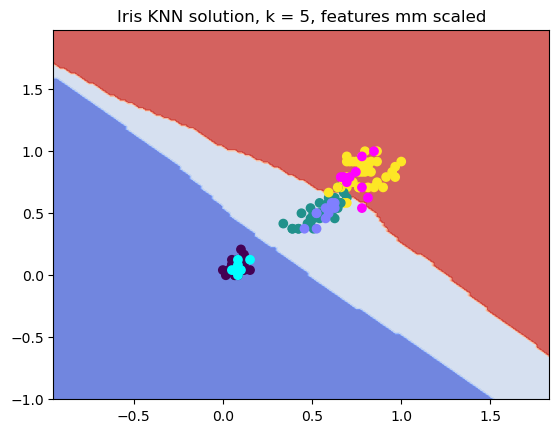

Train score: 0.9583333333333334
Test score: 0.9666666666666667


In [14]:
#transform training set
mm_pipeline = Pipeline([("mm_scaler", MinMaxScaler())])
X_transf = mm_pipeline.fit_transform(X_train)

knn_clf.fit(X_transf, y_train)

#using transformed training set and test set 
plotDecisionBoundary(knn_clf, mm_pipeline.transform(X_test), y_test, X_transf, 
                     y_train, title=f"Iris KNN solution, k = {k}, features mm scaled")

print("Train score:",knn_clf.score(X_transf, y_train))
print("Test score:",knn_clf.score(mm_pipeline.transform(X_test), y_test))

#result: one instance misclassified for the testing set nevertheless the training set has improved

In [15]:
#now we look at neighbors in a specific radius
from sklearn.neighbors import RadiusNeighborsClassifier

r = 1.0
knn_clf_r = RadiusNeighborsClassifier(radius=r) # radius in units of each feature (keep in mind the scales!)
knn_clf_r.fit(X_train, y_train)
plotDecisionBoundary(knn_clf_r, X_test, y_test, X_train, 
                     y_train, title=f"Iris KNN solution, radius = {r}")
print("Train score:",knn_clf_r.score(X_train, y_train))
print("Test score:",knn_clf_r.score(X_test, y_test))

# Problems with decision boundary visualization: there are features when there's no radius of 1 (upper or lower border)
#but: outliers could be classified in other cases
#solution for the boundary problem: update code (see next column below)

ValueError: No neighbors found for test samples array([    0,     1,     2, ..., 73697, 73698, 73699]), you can try using larger radius, giving a label for outliers, or considering removing them from your dataset.

In [16]:
#updated code for our RadiusNeighborsClassifier
def plotDecisionBoundaryNew(svc, X, y, X_train, y_train, title, x_min=None, x_max=None, y_min=None, y_max=None):
    h = .02
    if x_min is None:#assuming if x_min is None all are None
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    xx_r = xx.ravel()
    yy_r = yy.ravel()
    Z = svc.predict(np.c_[xx_r, yy_r])

    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train)
    plt.scatter(X[:, 0],X[:, 1],c=y, cmap=plt.cm.cool)
    plt.title(title)
    plt.show()

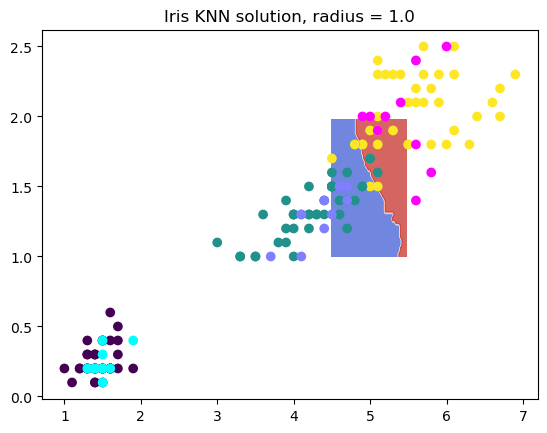

Train score: 0.95
Test score: 1.0


In [17]:
r = 1.0
knn_clf_r = RadiusNeighborsClassifier(radius=r) # radius in units of each feature (keep in mind the scales!)
knn_clf_r.fit(X_train, y_train)
plotDecisionBoundaryNew(knn_clf_r, X_test, y_test, X_train, 
                     y_train, title=f"Iris KNN solution, radius = {r}",
                       x_min=4.5, x_max=5.5, y_min=1, y_max=2)
print("Train score:",knn_clf_r.score(X_train, y_train))
print("Test score:",knn_clf_r.score(X_test, y_test))

#result: no visulization withing radius of 1, but we can still see the decision boundary

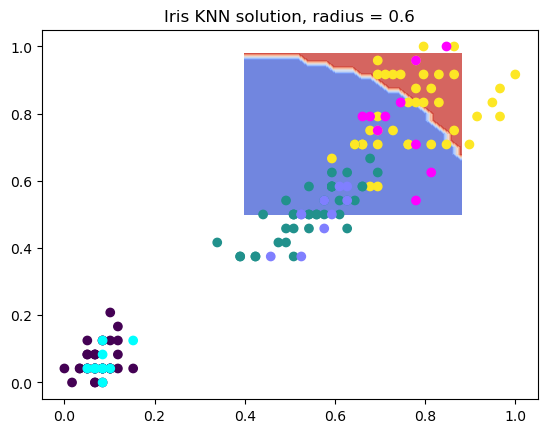

Train score: 0.8166666666666667
Test score: 0.7


In [18]:
r = .6
knn_clf_r = RadiusNeighborsClassifier(radius=r) # radius in units of each feature (keep in mind the scales!)
knn_clf_r.fit(X_transf, y_train)
plotDecisionBoundaryNew(knn_clf_r, mm_pipeline.transform(X_test), y_test, X_transf, 
                     y_train, title=f"Iris KNN solution, radius = {r}",
                       x_min=0.4, x_max=.9, y_min=0.5, y_max=1)
print("Train score:",knn_clf_r.score(X_transf, y_train))
print("Test score:",knn_clf_r.score(mm_pipeline.transform(X_test), y_test))